# Kahoot! challenge autumn 2023
# Data & Insights Intern
Brage Helgesen Jåsund

In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn3
import folium
from geopy.geocoders import Nominatim

In [2]:
# Load the datasets
cwur_data = pd.read_csv('cwurData.csv')
education_expenditure_supplementary_data = pd.read_csv('education_expenditure_supplementary_data.csv', engine='python')
educational_attainment_supplementary_data = pd.read_csv('educational_attainment_supplementary_data.csv')
school_and_country_table = pd.read_csv('school_and_country_table.csv')
shanghai_data = pd.read_csv('shanghaiData.csv')
times_data = pd.read_csv('timesData.csv')

# Display the first few rows of each dataset to get an overview
cwur_data.head(), education_expenditure_supplementary_data.head(), educational_attainment_supplementary_data.head(), school_and_country_table.head(), shanghai_data.head(), times_data.head()

(   world_rank                            institution         country  \
 0           1                     Harvard University             USA   
 1           2  Massachusetts Institute of Technology             USA   
 2           3                    Stanford University             USA   
 3           4                University of Cambridge  United Kingdom   
 4           5     California Institute of Technology             USA   
 
    national_rank  quality_of_education  alumni_employment  quality_of_faculty  \
 0              1                     7                  9                   1   
 1              2                     9                 17                   3   
 2              3                    17                 11                   5   
 3              1                    10                 24                   4   
 4              4                     2                 29                   7   
 
    publications  influence  citations  broad_impact  patents   sc

In [3]:
# Cleaning the data
max_broad_impact = cwur_data['broad_impact'].max()
cwur_data['broad_impact'].fillna(max_broad_impact + 1, inplace=True)

shanghai_data.dropna(subset=['university_name'], inplace=True)
shanghai_data['total_score'].fillna(shanghai_data['total_score'].mean(), inplace=True)

# Handling range rankings in the 'world_rank' column
def handle_range_ranking(rank):
    if '-' in rank:
        start, end = rank.split('-')
        return (int(start) + int(end)) / 2
    elif '=' in rank:
        return int(rank.replace('=', ''))
    else:
        return int(rank)

times_data['world_rank'] = times_data['world_rank'].apply(handle_range_ranking)

In [4]:
# Extracting the top 100 universities from each ranking
top_100_times = times_data[times_data['year'] == 2015].head(100)['university_name'].tolist()
top_100_shanghai = shanghai_data[shanghai_data['year'] == 2015].head(100)['university_name'].tolist()
top_100_cwur = cwur_data[cwur_data['year'] == 2015].head(100)['institution'].tolist()

# Finding the common universities among the top 100 of each ranking
common_universities_times_shanghai = set(top_100_times).intersection(top_100_shanghai)
common_universities_times_cwur = set(top_100_times).intersection(top_100_cwur)
common_universities_shanghai_cwur = set(top_100_shanghai).intersection(top_100_cwur)

# Finding universities that are in the top 100 of all three rankings
common_universities_all = set(top_100_times).intersection(top_100_shanghai).intersection(top_100_cwur)

# Returning the number of common universities between each pair of rankings and the number common to all three rankings
len(common_universities_times_shanghai), len(common_universities_times_cwur), len(common_universities_shanghai_cwur), len(common_universities_all)

(49, 54, 49, 35)

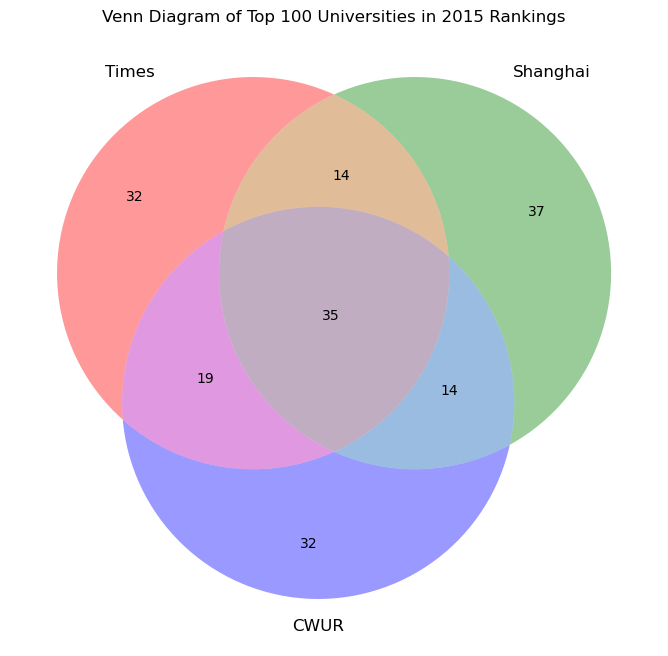

In [5]:
# Create a Venn diagram to visualize the overlaps between the top 100 universities from each ranking
plt.figure(figsize=(10, 8))
venn3([set(top_100_times), set(top_100_shanghai), set(top_100_cwur)],
      set_labels=('Times', 'Shanghai', 'CWUR'))
plt.title('Venn Diagram of Top 100 Universities in 2015 Rankings')
plt.show()

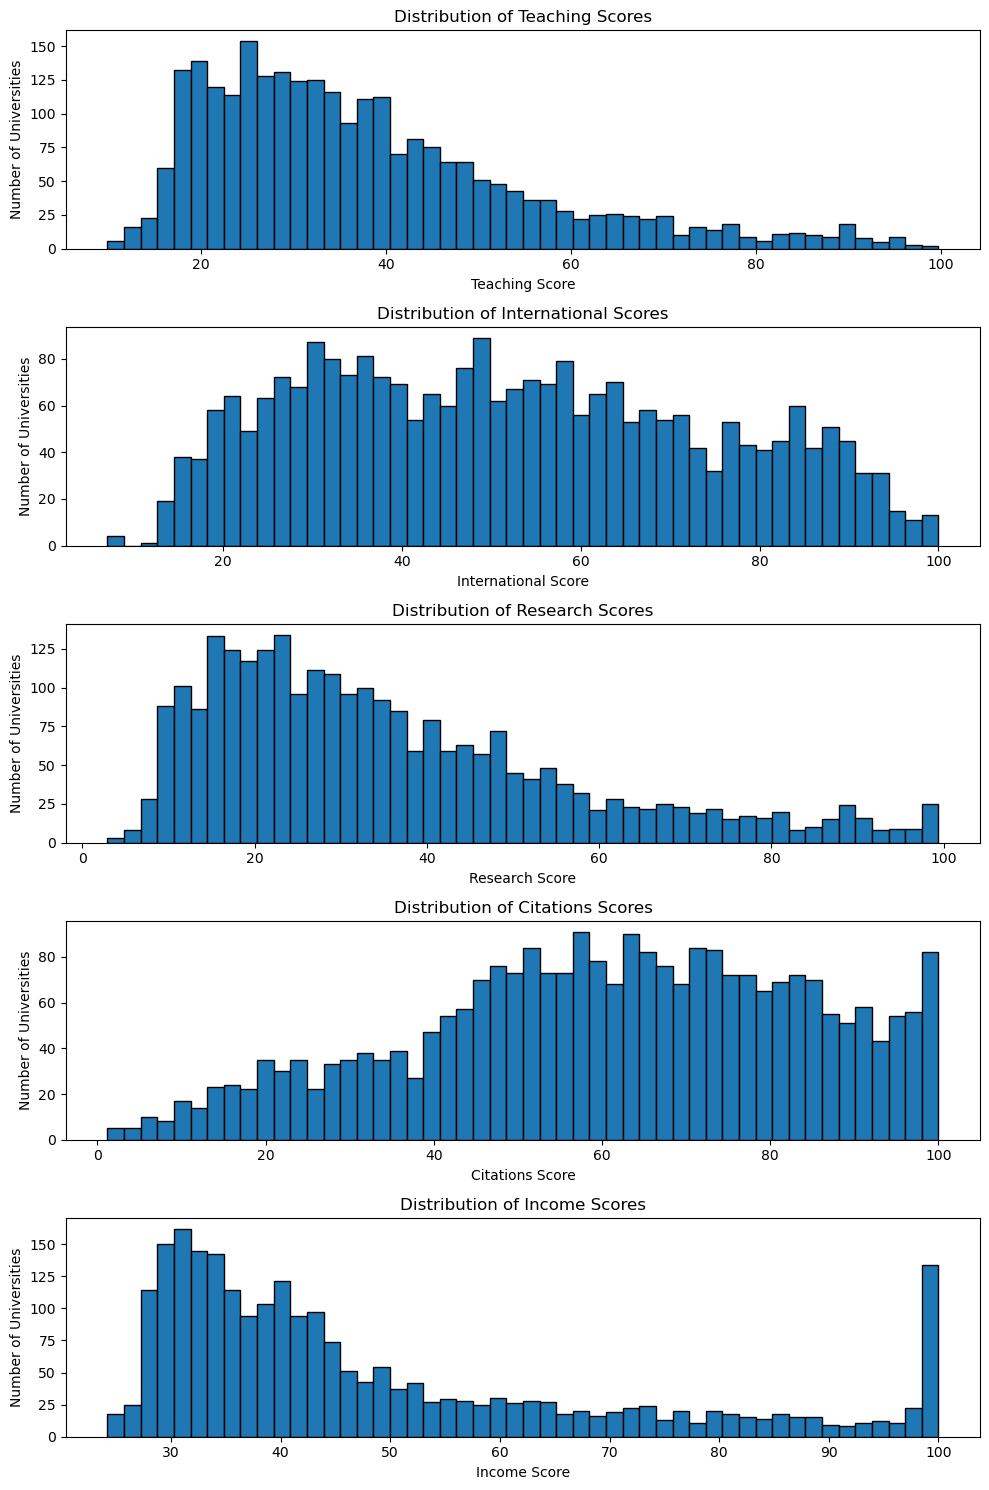

In [6]:
# Converting score columns to numeric values and handling non-numeric entries
for col in ['teaching', 'international', 'research', 'citations', 'income']:
    times_data[col] = pd.to_numeric(times_data[col], errors='coerce')

# Plotting scores distributions for timesData
fig, ax = plt.subplots(5, 1, figsize=(10, 15))
score_columns = ['teaching', 'international', 'research', 'citations', 'income']
titles = ['Distribution of Teaching Scores', 'Distribution of International Scores', 'Distribution of Research Scores', 'Distribution of Citations Scores', 'Distribution of Income Scores']
for i, col in enumerate(score_columns):
    times_data[col].plot(ax=ax[i], kind='hist', bins=50, edgecolor='black')
    ax[i].set_title(titles[i])
    ax[i].set_xlabel(col.capitalize() + ' Score')
    ax[i].set_ylabel('Number of Universities')

plt.tight_layout()
plt.show()

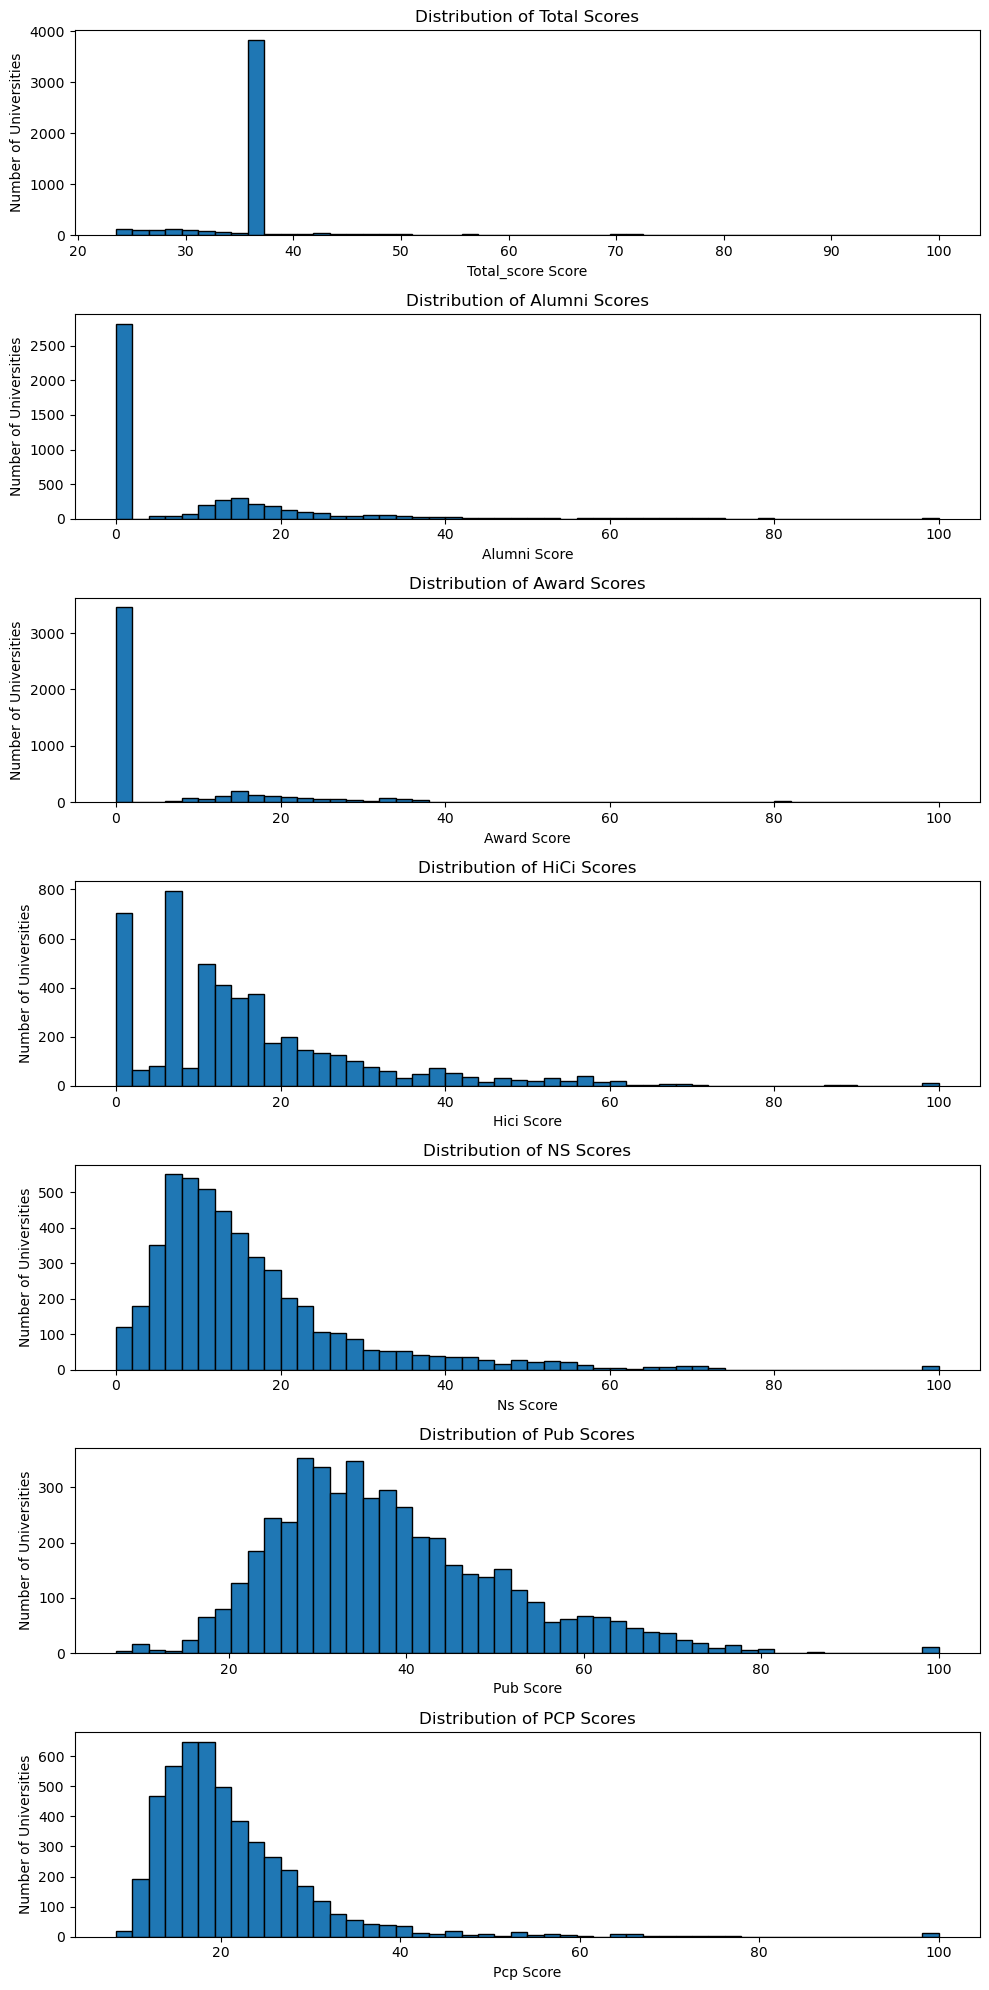

In [7]:
# Plotting scores distributions for shanghai_data
fig, ax = plt.subplots(7, 1, figsize=(10, 20))
shanghai_columns = ['total_score', 'alumni', 'award', 'hici', 'ns', 'pub', 'pcp']
shanghai_titles = ['Distribution of Total Scores', 'Distribution of Alumni Scores', 'Distribution of Award Scores', 'Distribution of HiCi Scores', 'Distribution of NS Scores', 'Distribution of Pub Scores', 'Distribution of PCP Scores']
for i, col in enumerate(shanghai_columns):
    shanghai_data[col] = pd.to_numeric(shanghai_data[col], errors='coerce')
    shanghai_data[col].plot(ax=ax[i], kind='hist', bins=50, edgecolor='black')
    ax[i].set_title(shanghai_titles[i])
    ax[i].set_xlabel(col.capitalize() + ' Score')
    ax[i].set_ylabel('Number of Universities')

plt.tight_layout()
plt.show()

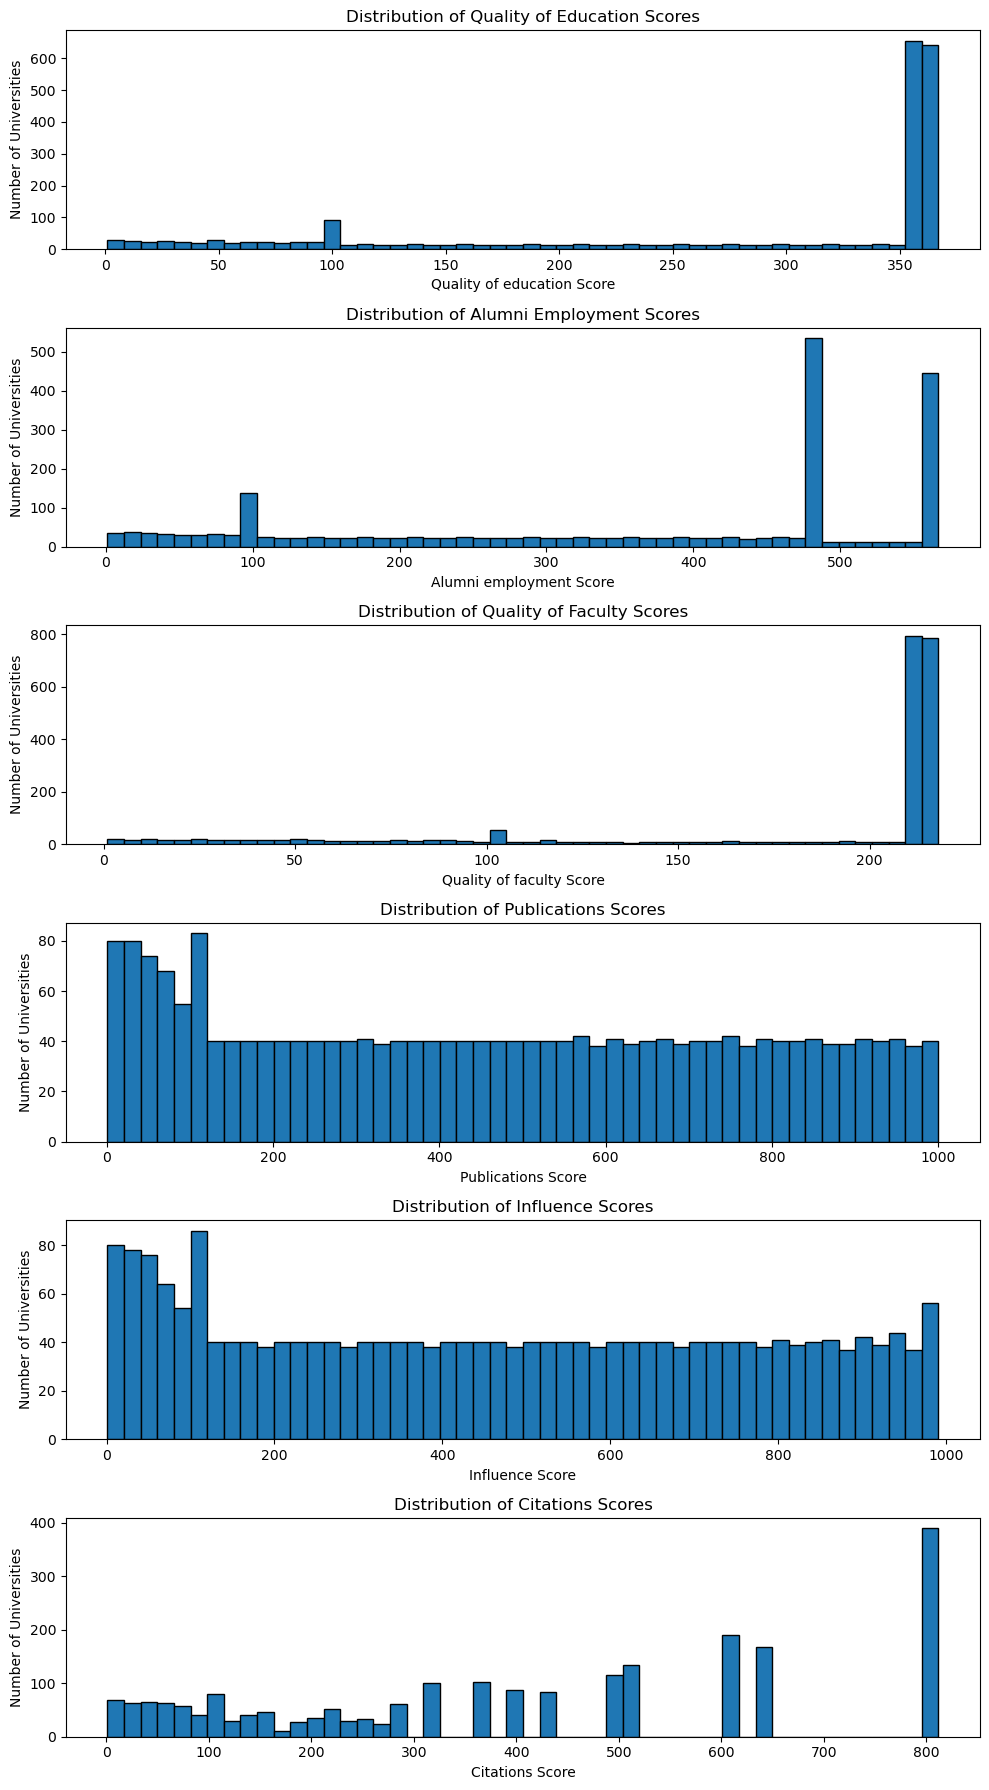

In [8]:
# Plotting scores distributions for cwur_data
fig, ax = plt.subplots(6, 1, figsize=(10, 18))
cwur_columns = ['quality_of_education', 'alumni_employment', 'quality_of_faculty', 'publications', 'influence', 'citations']
cwur_titles = ['Distribution of Quality of Education Scores', 'Distribution of Alumni Employment Scores', 'Distribution of Quality of Faculty Scores', 'Distribution of Publications Scores', 'Distribution of Influence Scores', 'Distribution of Citations Scores']
for i, col in enumerate(cwur_columns):
    cwur_data[col].plot(ax=ax[i], kind='hist', bins=50, edgecolor='black')
    ax[i].set_title(cwur_titles[i])
    ax[i].set_xlabel(col.replace('_', ' ').capitalize() + ' Score')
    ax[i].set_ylabel('Number of Universities')

plt.tight_layout()
plt.show()

In [9]:
# Recreating the 'average_rank' column
times_data['average_rank'] = times_data['world_rank'].apply(lambda x: (int(str(x).split('-')[0]) + int(str(x).split('-')[-1])) / 2 if '-' in str(x) else int(x))

# Correlation Analysis for Times Ranking System using 'average_rank'
times_corr = times_data[['teaching', 'international', 'research', 'citations', 'income', 'average_rank']].corr()
times_corr_average_rank = times_corr['average_rank'].sort_values(ascending=True)  # Lower rank is better, so we sort in ascending order

# Displaying the correlation values
times_corr_average_rank

citations       -0.803925
research        -0.759342
teaching        -0.716650
international   -0.385101
income          -0.262027
average_rank     1.000000
Name: average_rank, dtype: float64

In [10]:
# Correlation Analysis for Shanghai Ranking System
shanghai_corr = shanghai_data[['total_score', 'alumni', 'award', 'hici', 'ns', 'pub', 'pcp']].corr()
shanghai_corr_total_score = shanghai_corr['total_score'].sort_values(ascending=False)  # Higher score is better, so we sort in descending order

# Displaying the correlation values
shanghai_corr_total_score

total_score    1.000000
award          0.560591
ns             0.529876
pcp            0.488366
alumni         0.480914
hici           0.462392
pub            0.279958
Name: total_score, dtype: float64

In [11]:
# Correlation Analysis for CWUR Ranking System
cwur_corr = cwur_data[['world_rank', 'quality_of_education', 'alumni_employment', 'quality_of_faculty', 'publications', 'influence', 'citations', 'broad_impact', 'patents', 'score']].corr()
cwur_corr_world_rank = cwur_corr['world_rank'].sort_values(ascending=True)  # Lower rank is better, so we sort in ascending order

# Displaying the correlation values
cwur_corr_world_rank

score                  -0.549098
broad_impact            0.554597
quality_of_faculty      0.663864
alumni_employment       0.668529
quality_of_education    0.676166
patents                 0.698214
citations               0.856573
influence               0.895871
publications            0.923037
world_rank              1.000000
Name: world_rank, dtype: float64

In [12]:
# For the Times dataset:
times_corr_average_rank = times_corr_average_rank.drop('average_rank')  # Exclude the column itself
top_3_times = times_corr_average_rank.head(3)

# For the Shanghai dataset:
shanghai_corr_total_score = shanghai_corr_total_score.drop('total_score')  # Exclude the column itself
top_3_shanghai = shanghai_corr_total_score.head(3)

# For the CWUR dataset:
cwur_corr_world_rank = cwur_corr_world_rank.drop('world_rank')  # Exclude the column itself
top_3_cwur = cwur_corr_world_rank.head(3)

# Combine the correlations and identify the top 3 overall:
combined_correlations = pd.concat([times_corr_average_rank, shanghai_corr_total_score, cwur_corr_world_rank])
top_3_overall = combined_correlations.sort_values(ascending=False).head(3)

# Display the results:
print("Top 3 Correlations for Times Dataset:")
print(top_3_times)
print("\nTop 3 Correlations for Shanghai Dataset:")
print(top_3_shanghai)
print("\nTop 3 Correlations for CWUR Dataset:")
print(top_3_cwur)
print("\nTop 3 Correlations Overall:")
print(top_3_overall)

Top 3 Correlations for Times Dataset:
citations   -0.803925
research    -0.759342
teaching    -0.716650
Name: average_rank, dtype: float64

Top 3 Correlations for Shanghai Dataset:
award    0.560591
ns       0.529876
pcp      0.488366
Name: total_score, dtype: float64

Top 3 Correlations for CWUR Dataset:
score                -0.549098
broad_impact          0.554597
quality_of_faculty    0.663864
Name: world_rank, dtype: float64

Top 3 Correlations Overall:
publications    0.923037
influence       0.895871
citations       0.856573
dtype: float64


In [13]:
# Merging the Shanghai ranking data with the school_and_country_table to get country information
shanghai_with_country = pd.merge(shanghai_data, school_and_country_table, left_on='university_name', right_on='school_name', how='left')
# Merging the Times ranking data with the expenditure data
times_merged = pd.merge(times_data, education_expenditure_supplementary_data, left_on='country', right_on='country', how='inner')
# Merging the Shanghai (with country) ranking data with the expenditure data
shanghai_merged = pd.merge(shanghai_with_country, education_expenditure_supplementary_data, left_on='country', right_on='country', how='inner')
# Merging the CWUR ranking data with the expenditure data
cwur_merged = pd.merge(cwur_data, education_expenditure_supplementary_data, left_on='country', right_on='country', how='inner')
# Checking the merged data
times_merged.head(), shanghai_merged.head(), cwur_merged.head()

(   world_rank          university_name         country  teaching  \
 0         6.0  University of Cambridge  United Kingdom      90.5   
 1         6.0  University of Cambridge  United Kingdom      90.5   
 2         6.0  University of Cambridge  United Kingdom      90.5   
 3         6.0  University of Cambridge  United Kingdom      90.5   
 4         6.0  University of Cambridge  United Kingdom      90.5   
 
    international  research  citations  income total_score num_students  ...  \
 0           77.7      94.1       94.0    57.0        91.2       18,812  ...   
 1           77.7      94.1       94.0    57.0        91.2       18,812  ...   
 2           77.7      94.1       94.0    57.0        91.2       18,812  ...   
 3           77.7      94.1       94.0    57.0        91.2       18,812  ...   
 4           77.7      94.1       94.0    57.0        91.2       18,812  ...   
 
    year average_rank                          institute_type  \
 0  2011            6                

In [14]:
# Correlation Analysis for Times Ranking System using 'average_rank' and expenditure for the year 2011
times_expenditure_corr_2011 = times_merged[['average_rank', '2011']].corr().iloc[0, 1]
# Correlation Analysis for Shanghai Ranking System using 'total_score' and expenditure for the year 2011
shanghai_expenditure_corr_2011 = shanghai_merged[['total_score', '2011']].corr().iloc[0, 1]
# Correlation Analysis for CWUR Ranking System using 'world_rank' and expenditure for the year 2011
cwur_expenditure_corr_2011 = cwur_merged[['world_rank', '2011']].corr().iloc[0, 1]
# Displaying the correlation values for each ranking system
times_expenditure_corr_2011, shanghai_expenditure_corr_2011, cwur_expenditure_corr_2011

(-0.03568328806187922, -0.006975814890098521, -0.033979651415346375)

In [15]:
# Finding the common universities among the top 100 of each pair of rankings
common_universities_times_shanghai = set(top_100_times).intersection(top_100_shanghai)
common_universities_times_cwur = set(top_100_times).intersection(top_100_cwur)
common_universities_shanghai_cwur = set(top_100_shanghai).intersection(top_100_cwur)

# Finding universities that are in the top 100 of at least two rankings
universities_in_two_rankings = common_universities_times_shanghai.union(common_universities_times_cwur).union(common_universities_shanghai_cwur)

# Displaying the identified universities
print("Universities that are in the top 100 of at least two rankings:")
print(sorted(universities_in_two_rankings))

Universities that are in the top 100 of at least two rankings:
['Arizona State University', 'Boston University', 'Brown University', 'California Institute of Technology', 'Carnegie Mellon University', 'Columbia University', 'Cornell University', 'Duke University', 'Emory University', 'Erasmus University Rotterdam', 'Georgia Institute of Technology', 'Ghent University', 'Harvard University', 'Heidelberg University', 'Imperial College London', 'Johns Hopkins University', 'KU Leuven', 'Karolinska Institute', "King's College London", 'Kyoto University', 'Leiden University', 'Massachusetts Institute of Technology', 'McGill University', 'McMaster University', 'Michigan State University', 'National University of Singapore', 'New York University', 'Northwestern University', 'Osaka University', 'Peking University', 'Princeton University', 'Rice University', 'Rockefeller University', 'Seoul National University', 'Stanford University', 'Stockholm University', 'The University of Queensland', 'Tsin

In [16]:
# Merging shanghai_data with school_country_df to get the country information
shanghai_data_merged = shanghai_data.merge(school_and_country_table, left_on='university_name', right_on='school_name', how='left')

# Extracting the countries of the top 100 universities from each ranking
top_100_countries_times = times_data[times_data['university_name'].isin(top_100_times)]['country'].unique().tolist()
top_100_countries_shanghai = shanghai_data_merged[shanghai_data_merged['university_name'].isin(top_100_shanghai)]['country'].unique().tolist()
top_100_countries_cwur = cwur_data[cwur_data['institution'].isin(top_100_cwur)]['country'].unique().tolist()

# Finding the common countries among the top 100 of each ranking
common_countries_times_shanghai = set(top_100_countries_times).intersection(top_100_countries_shanghai)
common_countries_times_cwur = set(top_100_countries_times).intersection(top_100_countries_cwur)
common_countries_shanghai_cwur = set(top_100_countries_shanghai).intersection(top_100_countries_cwur)

# Finding countries that are in the top 100 of at least two rankings
countries_in_two_rankings = common_countries_times_shanghai.union(common_countries_times_cwur).union(common_countries_shanghai_cwur)

# Displaying the identified countries
print("Countries that have universities in the top 100 of at least two rankings:")
print(sorted(countries_in_two_rankings))

Countries that have universities in the top 100 of at least two rankings:
['Australia', 'Belgium', 'Canada', 'China', 'Denmark', 'France', 'Germany', 'Japan', 'Netherlands', 'Norway', 'Singapore', 'South Korea', 'Sweden', 'Switzerland', 'United Kingdom', 'United States of America']


In [17]:
# Extracting the countries of the universities that are in the top 100 of at least two rankings
universities_countries_df = school_and_country_table[school_and_country_table['school_name'].isin(universities_in_two_rankings)]

# Counting the number of schools from each country
country_counts = universities_countries_df['country'].value_counts().reset_index()
country_counts.columns = ['country', 'count']

# Creating a world map
world_map = folium.Map(location=[20,0], zoom_start=2, tiles="cartodbpositron")

# Adding a Choropleth layer to color countries based on the number of universities
folium.Choropleth(
    geo_data="https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/world-countries.json",
    name="choropleth",
    data=country_counts,
    columns=["country", "count"],
    key_on="feature.properties.name",
    fill_color="YlGnBu",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Number of Universities in Top 100 of At Least Two Rankings"
).add_to(world_map)

# Adding numbers on top of the countries
geolocator = Nominatim(user_agent="geoapiExercises")
for index, row in country_counts.iterrows():
    location = geolocator.geocode(row['country'])
    if location:
        folium.Marker(
            [location.latitude, location.longitude],
            icon=folium.DivIcon(html=f"""<div style="font-size: 12pt; color: 'black';">{row['count']}</div>""")
        ).add_to(world_map)

# Displaying the map
world_map


In [18]:
# Handling the world_rank column that contains ranges
def convert_rank(rank):
    if '-' in str(rank):
        start, end = rank.split('-')
        return (int(start) + int(end)) / 2
    return float(rank)

# Applying the conversion function to the world_rank column
times_data['world_rank'] = times_data['world_rank'].apply(convert_rank)

# Grouping by country and calculating the average world rank for each country for the year 2011
country_avg_rank_2011 = times_data[times_data['year'] == 2011].groupby('country')['world_rank'].mean().sort_values()

# Displaying the top 10 countries with the highest average university rankings
country_avg_rank_2011.head(10)

country
United States of America     71.847222
France                       80.250000
Hong Kong                    80.500000
Switzerland                  83.666667
Republic of Ireland          85.000000
Australia                    90.571429
Japan                        91.400000
South Korea                 101.500000
Finland                     102.000000
Singapore                   104.000000
Name: world_rank, dtype: float64

In [19]:
# Sorting the countries based on their direct expenditure on education for the year 2011
top_education_expenditure_2011 = education_expenditure_supplementary_data.sort_values(by='2011', ascending=False)

# Displaying the top 10 countries with the highest direct expenditure on education for 2011
top_education_expenditure_2011[['country', '2011']].head(10)

,country,2011
229,Denmark,7.9
236,Iceland,7.7
241,"Korea, Republic of",7.6
245,New Zealand,7.5
7,Denmark,7.5
24,Norway,7.3
238,Israel,7.3
256,United States,6.9
14,Iceland,6.9
225,Belgium,6.6


These countries invest a significant portion of their GDP in education, indicating a strong commitment to educational development. Targeting these countries with marketing and sales efforts for educational tools like Kahoot! could be a strategic move.

In [20]:
# List of top 10 countries based on average university rankings
top_ranked_countries = [
    "United States of America", "France", "Hong Kong", "Switzerland", 
    "Republic of Ireland", "Australia", "Japan", "South Korea", 
    "Finland", "Singapore"
]

# List of top 10 countries based on direct expenditure on education
top_education_expenditure_countries = [
    "Denmark", "Iceland", "Korea, Republic of", "New Zealand", 
    "Denmark", "Norway", "Israel", "United States of America", 
    "Iceland", "Belgium"
]

# Convert the lists to sets for easy comparison
set_ranked_countries = set(top_ranked_countries)
set_expenditure_countries = set(top_education_expenditure_countries)

# Find countries that are common in both lists
common_countries = set_ranked_countries.intersection(set_expenditure_countries)

# Find countries that are unique to the university ranking list
unique_to_ranking = set_ranked_countries - set_expenditure_countries

# Find countries that are unique to the expenditure list
unique_to_expenditure = set_expenditure_countries - set_ranked_countries

print("Common countries:", common_countries)
print("Countries unique to university ranking:", unique_to_ranking)
print("Countries unique to education expenditure:", unique_to_expenditure)

Common countries: {'United States of America'}
Countries unique to university ranking: {'Australia', 'South Korea', 'Republic of Ireland', 'Finland', 'Switzerland', 'France', 'Japan', 'Singapore', 'Hong Kong'}
Countries unique to education expenditure: {'Belgium', 'Norway', 'Denmark', 'Korea, Republic of', 'Israel', 'Iceland', 'New Zealand'}


In [21]:
# Convert world_rank to string
shanghai_data['world_rank'] = shanghai_data['world_rank'].astype(str)

# If the rank is a range, take the start of the range
shanghai_data['world_rank'] = shanghai_data['world_rank'].str.split('-').str[0]

# Convert the cleaned ranks to integers
shanghai_data['world_rank'] = pd.to_numeric(shanghai_data['world_rank'], errors='coerce')

# Now, you can filter the top 100 universities
top_shanghai = shanghai_data[shanghai_data['world_rank'] <= 100]

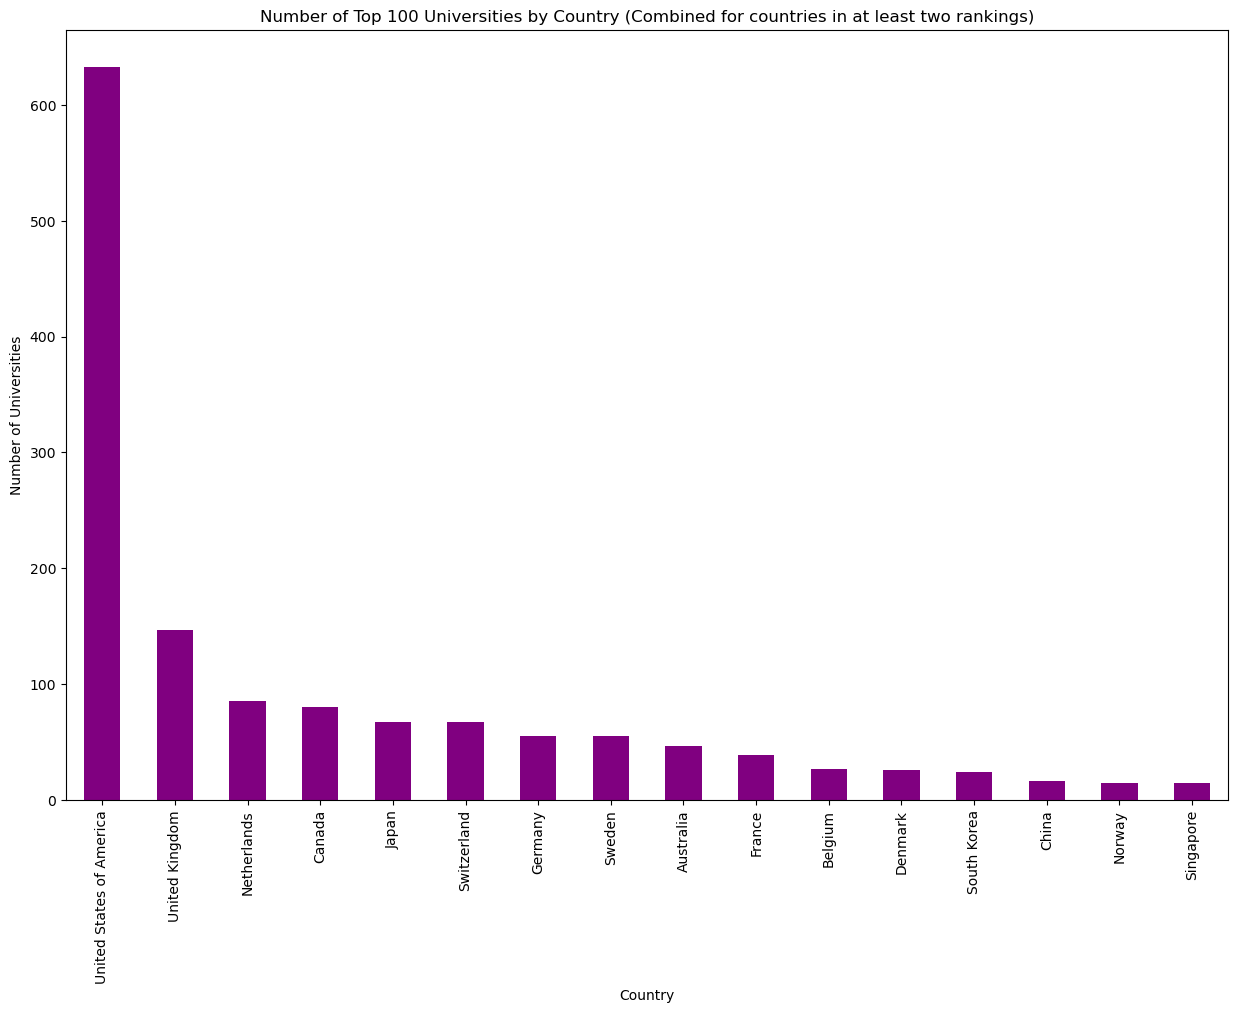

In [22]:
# Counting the number of top universities by country for each ranking system
times_country_counts = times_data[times_data['university_name'].isin(top_100_times)]['country'].value_counts()
shanghai_country_counts = shanghai_data_merged[shanghai_data_merged['university_name'].isin(top_100_shanghai)]['country'].value_counts()
cwur_country_counts = cwur_data[cwur_data['institution'].isin(top_100_cwur)]['country'].value_counts()

# Combining the counts
combined_counts = times_country_counts.add(shanghai_country_counts, fill_value=0).add(cwur_country_counts, fill_value=0)

# Filtering only the countries that are in countries_in_two_rankings
combined_counts = combined_counts[combined_counts.index.isin(countries_in_two_rankings)]

# Sorting the counts in descending order for better visualization
combined_counts = combined_counts.sort_values(ascending=False)

# Plotting the combined counts
plt.figure(figsize=(15, 10))
combined_counts.plot(kind='bar', color='purple')
plt.title('Number of Top 100 Universities by Country (Combined for countries in at least two rankings)')
plt.ylabel('Number of Universities')
plt.xlabel('Country')
plt.show()